
# Image Restoration using Autoencoders (FFDNet)

## Objective
This notebook demonstrates how to use Autoencoders for image restoration tasks such as denoising. Specifically, it implements the **FFDNet** model to reduce noise in images. The notebook also evaluates restoration performance using objective metrics like PSNR and SSIM.

## Overview
### Autoencoders
Autoencoders are a type of neural network designed for unsupervised learning tasks. They learn an efficient representation (encoding) of data, which can then be used for reconstruction.

- **Encoder**: Compresses the input into a latent space.
- **Decoder**: Reconstructs the input from the latent representation.

### Importance of Image Restoration
Images are often degraded by noise, blurriness, or missing pixels due to environmental or technical factors. Image restoration techniques are essential in fields like photography, medical imaging, and remote sensing.


## Environment Setup

- Required python verrsion is `3.7.*`

- Create a new virtual environment and install the required libraries listed in `requirements.txt` file.
```bash
conda create -n Image-Restoration python=3.7
conda activate Image-Restoration
pip install -r requirements.txt
```

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), "ffdnet"))

In [2]:
import time
import torch
from torch.autograd import Variable
import cv2
import logging

from ffdnet.utils import (
    load_image,
    load_FFDNET,
    handle_odd_sizes,
    normalize,
    load_logger,
    variable_to_cv2_image,
)

import os
from IPython.display import display, Image

In [3]:
logger = load_logger(name="Notebook", level=logging.DEBUG)

IntSlider(value=25, continuous_update=False, description='std', max=75)

Checkbox(value=True, description='Run model on CPU', indent=False)

FileChooser(path='/home/astanea/git-repos/projects/Autoencoders-for-Image-Restoration/data', filename='', titl…

/home/astanea/git-repos/projects/Autoencoders-for-Image-Restoration/data/CBSD68/105025.png


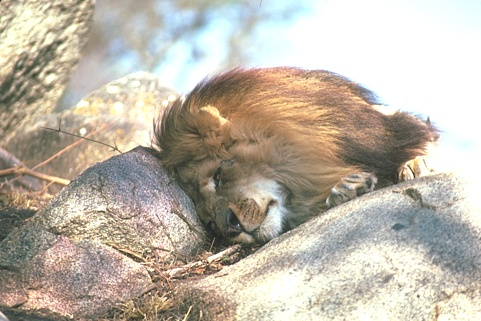

In [4]:
from widgets.loaders import (
    use_cpu_widget,
    sigma_widget,
    get_file_chooser,
    load_selected_path,
    browse_images
)

fc = get_file_chooser()

display(sigma_widget)
display(use_cpu_widget)
display(fc)
display(Image(filename=load_selected_path()))

### Load and Preprocess Image
The image is read, normalized, and prepared for processing. This includes handling odd dimensions and determining whether the image is **grayscale or RGB.**

In [5]:
input_image_path = load_selected_path()
USE_CPU = use_cpu_widget.value
SIGMA = sigma_widget.value
logger.debug(f"SIGMA: {SIGMA}")
# Normalize the noise level
SIGMA = SIGMA / 255.0

dtype = torch.FloatTensor if USE_CPU else torch.cuda.FloatTensor

logger.debug(f"input_image_path: {input_image_path}")
logger.debug(f"USE_CPU: {USE_CPU}")
logger.debug(f"SIGMA normalized: {SIGMA}")
logger.debug(f"dtype: {dtype}")

/home/astanea/git-repos/projects/Autoencoders-for-Image-Restoration/data/CBSD68/105025.png
2025-01-12 14:38:44  Notebook [DEBUG] : SIGMA: 25
2025-01-12 14:38:44  Notebook [DEBUG] : input_image_path: /home/astanea/git-repos/projects/Autoencoders-for-Image-Restoration/data/CBSD68/105025.png
2025-01-12 14:38:44  Notebook [DEBUG] : USE_CPU: True
2025-01-12 14:38:44  Notebook [DEBUG] : SIGMA normalized: 0.09803921568627451
2025-01-12 14:38:44  Notebook [DEBUG] : dtype: <class 'torch.FloatTensor'>


In [6]:
input_image, model_type, in_chn, rgb_den = load_image(input_image_path)
input_image, expanded_h, expanded_w = handle_odd_sizes(input_image)
input_image = normalize(input_image)
input_image = torch.Tensor(input_image)

logger.debug(f"Input image shape: {input_image.shape}")  # (B, C, H, W)
logger.debug(f"Input channels: {in_chn}")  # 1 for grayscale, 3 for color
logger.debug(f"RGB denoising: {rgb_den}")  # True or False
logger.debug(f"Model type: {model_type}")  # 'gray' or 'color'
logger.debug(f"Expanded height: {expanded_h}")  # True or False
logger.debug(f"Expanded width: {expanded_w}")  # True or False

2025-01-12 14:38:44  Notebook [DEBUG] : Input image shape: torch.Size([1, 3, 322, 482])
2025-01-12 14:38:44  Notebook [DEBUG] : Input channels: 3


2025-01-12 14:38:44  Notebook [DEBUG] : RGB denoising: True
2025-01-12 14:38:44  Notebook [DEBUG] : Model type: models/net_rgb.pth
2025-01-12 14:38:44  Notebook [DEBUG] : Expanded height: True
2025-01-12 14:38:44  Notebook [DEBUG] : Expanded width: True


### Load the FFDNet Model
The FFDNet model is loaded based on the image type (grayscale or color) and device (CPU or GPU).


In [7]:
model = load_FFDNET(
    model_type=os.path.join("./ffdnet", model_type), in_ch=in_chn, use_cpu=USE_CPU
)
model.eval()

logger.debug(f"Use CPU: {USE_CPU}")
logger.debug(f"Model: {model}")

2025-01-12 14:38:44  Notebook [DEBUG] : Use CPU: True
2025-01-12 14:38:44  Notebook [DEBUG] : Model: FFDNet(
  (intermediate_dncnn): IntermediateDnCNN(
    (itermediate_dncnn): Sequential(
      (0): Conv2d(15, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace)
      (5): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (6): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace)
      (8): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace)
      (11): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

### Add Noise to the Image
Simulates a noisy environment by adding Gaussian noise to the input image.

In [8]:
assert SIGMA >= 0, "Noise level must be positive"
assert SIGMA <= 75, "Noise level must be less than or equal to 75"

if SIGMA != 0:
    logger.info(f"Adding Gaussian noise with sigma: {SIGMA}")
    noise = torch.FloatTensor(input_image.size()).normal_(mean=0, std=SIGMA)
    noisy_image = input_image + noise
else:
    logger.info("No noise added")
    noisy_image = input_image.clone()

with torch.no_grad():
    input_image = Variable(input_image.type(dtype))
    noisy_image = Variable(noisy_image.type(dtype))
    noise_sigma = Variable(torch.FloatTensor([SIGMA]).type(dtype))

2025-01-12 14:38:44  Notebook [INFO] : Adding Gaussian noise with sigma: 0.09803921568627451


### Estimate Noise Level
Estimate the noise level in the noisy image using the `estimate_sigma` function from the `skimage.restoration` module. This estimated noise level will be used as an input to the FFDNet model for denoising.

In [9]:
from skimage.restoration import estimate_sigma

estimated_sigma = estimate_sigma(
    noisy_image.cpu().numpy().flatten(), multichannel=False
)
estimated_sigma = Variable(torch.FloatTensor([estimated_sigma]).type(dtype))

logger.info(f"Input noise sigma: {noise_sigma}")
logger.info(f"Estimated noise sigma: {estimated_sigma}")

2025-01-12 14:38:44  Notebook [INFO] : Input noise sigma: tensor([0.0980])
2025-01-12 14:38:44  Notebook [INFO] : Estimated noise sigma: tensor([0.1051])


### Denoise the Image
The FFDNet model is used to denoise the noisy image. The denoised image is obtained by subtracting the noise estimate from the noisy image. The time taken for the denoising process is also recorded.

In [10]:
start_time = time.time()

image_noise_estimate = model(noisy_image, estimated_sigma)
denoised_image = torch.clamp(noisy_image - image_noise_estimate, 0.0, 1.0)

stop_time = time.time()

elapsed_time = stop_time - start_time
logger.info(f"Elapsed time: {elapsed_time:.2f} seconds")

2025-01-12 14:38:45  Notebook [INFO] : Elapsed time: 0.37 seconds


### Calculate and Display Differences
Calculate the differences between the denoised image and the input image, as well as the noisy image and the input image. These differences are visualized to better understand the denoising performance.

In [11]:
diff_out = 2 * (denoised_image - input_image) + 0.5
diff_noise = 2 * (noisy_image - input_image) + 0.5

### Fix Image Size
This cell adjusts the image size if the dimensions were expanded to handle odd sizes. It removes the last row or column if the image was expanded in height or width, respectively.

In [12]:
# Fix the image size if expanded
logger.info("Fixing the image size")
logger.debug(f"expanded_h: {expanded_h}")
logger.debug(f"expanded_w: {expanded_w}")

logger.debug("Before removing the last row/column")
logger.debug(f"Input image shape: {input_image.shape}")
logger.debug(f"Noisy image shape: {noisy_image.shape}")
logger.debug(f"Denoised image shape: {denoised_image.shape}")

if expanded_h:
    logger.info("Removing the last row")
    input_image = input_image[:, :, :-1, :]
    denoised_image = denoised_image[:, :, :-1, :]
    noisy_image = noisy_image[:, :, :-1, :]

if expanded_w:
    logger.info("Removing the last column")
    input_image = input_image[:, :, :, :-1]
    denoised_image = denoised_image[:, :, :, :-1]
    noisy_image = noisy_image[:, :, :, :-1]

logger.debug("After removing the last row/column")
logger.debug(f"Input image shape: {input_image.shape}")
logger.debug(f"Noisy image shape: {noisy_image.shape}")
logger.debug(f"Denoised image shape: {denoised_image.shape}")

2025-01-12 14:38:45  Notebook [INFO] : Fixing the image size
2025-01-12 14:38:45  Notebook [DEBUG] : expanded_h: True
2025-01-12 14:38:45  Notebook [DEBUG] : expanded_w: True
2025-01-12 14:38:45  Notebook [DEBUG] : Before removing the last row/column
2025-01-12 14:38:45  Notebook [DEBUG] : Input image shape: torch.Size([1, 3, 322, 482])
2025-01-12 14:38:45  Notebook [DEBUG] : Noisy image shape: torch.Size([1, 3, 322, 482])
2025-01-12 14:38:45  Notebook [DEBUG] : Denoised image shape: torch.Size([1, 3, 322, 482])
2025-01-12 14:38:45  Notebook [INFO] : Removing the last row
2025-01-12 14:38:45  Notebook [INFO] : Removing the last column
2025-01-12 14:38:45  Notebook [DEBUG] : After removing the last row/column
2025-01-12 14:38:45  Notebook [DEBUG] : Input image shape: torch.Size([1, 3, 321, 481])
2025-01-12 14:38:45  Notebook [DEBUG] : Noisy image shape: torch.Size([1, 3, 321, 481])
2025-01-12 14:38:45  Notebook [DEBUG] : Denoised image shape: torch.Size([1, 3, 321, 481])


In [ ]:
from sewar.full_ref import ssim, mse, psnr
import pandas as pd

if rgb_den:
    logger.info("RGB denoising")
else:
    logger.info("Grayscale denoising")


denoised_image_ = denoised_image.detach().cpu().numpy().squeeze(0)
input_image_ = input_image.cpu().numpy().squeeze(0)
noisy_image_ = noisy_image.cpu().numpy().squeeze(0)

logger.debug(f"denoised_image_: {denoised_image_.shape}")
logger.debug(f"input_image_: {input_image_.shape}")
logger.debug(f"noisy_image_: {noisy_image_.shape}")

columns = [
    "experiment",
    "Noisy/Original",
    "Denoised/Original",
]

SSIM_IDX = 0  # Index of SSIM value in the tuple returned by the ssim function
results = pd.DataFrame(columns=columns)

if SIGMA > 0:
    # Calculates peak signal-to-noise ratio
    experiment_data = {
        "experiment": "PSNR",
        "Noisy/Original": psnr(noisy_image_, input_image_, MAX=1),
        "Denoised/Original": psnr(denoised_image_, input_image_, MAX=1),
    }
    results = results.append(experiment_data, ignore_index=True)

    # calculates mean squared error
    experiment_data = {
        "experiment": "MSE",
        "Noisy/Original": mse(noisy_image_, input_image_),
        "Denoised/Original": mse(denoised_image_, input_image_),
    }
    results = results.append(experiment_data, ignore_index=True)

    # calculates structural similarity index
    experiment_data = {
        "experiment": "SSIM",
        "Noisy/Original": ssim(noisy_image_, input_image_, MAX=1, mode="same")[
            SSIM_IDX
        ],
        "Denoised/Original": ssim(denoised_image_, input_image_, MAX=1, mode="same")[
            SSIM_IDX
        ],
    }
    results = results.append(experiment_data, ignore_index=True)

else:
    logger.info("# No noise was added, cannot compute PSNR")

print(results)

2025-01-12 14:38:45  Notebook [INFO] : RGB denoising
2025-01-12 14:38:45  Notebook [DEBUG] : denoised_image_: (3, 321, 481)
2025-01-12 14:38:45  Notebook [DEBUG] : input_image_: (3, 321, 481)
2025-01-12 14:38:45  Notebook [DEBUG] : noisy_image_: (3, 321, 481)
  experiment  Noisy/Original  Denoised/Original
0       PSNR       20.167738          29.780372
1      PSNRB       20.211452          27.144812
2        MSE        0.009621           0.001052
3       SSIM        0.982432           0.997816


In [14]:
image_labels = [
    "Denoised Image",
    "Input Image",
    "Noisy Image",
    "Difference: Denoised - Input",
    "Difference: Noisy - Input",
]
images = [denoised_image, input_image, noisy_image, diff_out, diff_noise]
images = list(map(variable_to_cv2_image, images))

if rgb_den:
    images = list(map(lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB), images))

### Visualize Results


In [ ]:
browse_images(images=images, labels=image_labels, rgb_den=rgb_den)

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…